In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: cuda
Device name: NVIDIA GeForce GTX 1650


In [14]:
data = pd.read_csv("Dataset_English_Hindi.csv")
data.sample(5)

,English,Hindi
25572,"He has tenderness to Arjasha Hindi poetry, ver...",उन्होंने हिन्दी कविता को बृजभाषा की कोमलता दी ...
94699,So civilisation is not always an ally but some...,इस तरह सभ्यता हमेशा संस्कृति की मित्र रही होती...
79372,The script of her unnamed film is still being ...,ताजा फिल्म की पटकथा लिखी जा रही है पर वे कहती ...
31285,This is enclosed by two water channels,यह दो कुल्याओं द्वारा द्विभाजित है।
41178,index of presidents,अमेरिका के राष्ट्रपतियों की सूची


In [15]:
mask = data['English'].apply(lambda x: isinstance(x, str)) & data['Hindi'].apply(lambda x: isinstance(x, str))
data = data.loc[mask].copy()
data['English'] = data['English'].str.lower()
data['Hindi'] = data['Hindi'].str.lower()

In [16]:
MAX_SENT_LEN = 15
data = data[data['English'].str.split().apply(len) < MAX_SENT_LEN].copy()
data.reset_index(drop=True, inplace=True)
print(f"Rows after filtering: {len(data)}")

Rows after filtering: 77743


<Axes: title={'center': 'Distribution of English Sentence Lengths'}, ylabel='Frequency'>

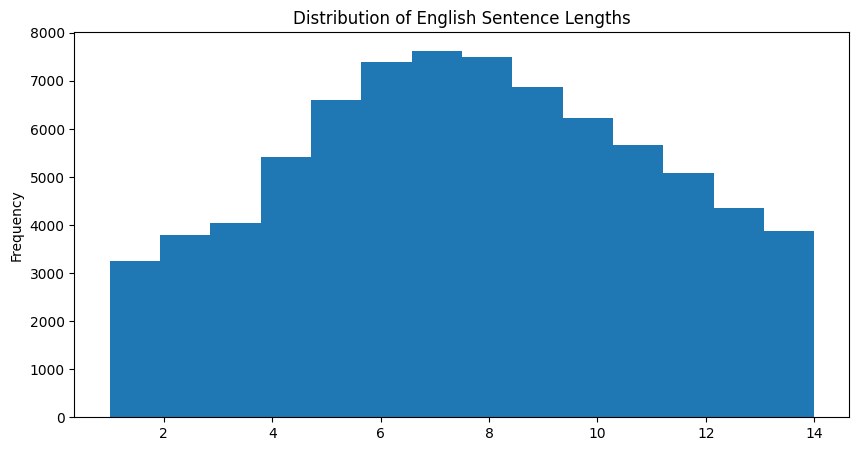

In [17]:
data['English'].str.split().apply(len).plot(kind='hist', bins=14, title='Distribution of English Sentence Lengths', figsize=(10, 5))

In [18]:
class Tokenizer:
    def __init__(self, texts):
        self.oov_token = "<|unknown|>"
        self.start_token = "<|startoftext|>"
        self.end_token = "<|endoftext|>"
        self.padding_token = "<|pad|>"
        self.word_index = {self.oov_token: 0, self.start_token: 1, self.end_token: 2, self.padding_token: 3}
    
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')

            text = text.split()
            for word in text:
                if word not in self.word_index:
                    self.word_index[word] = len(self.word_index) + 1
        self.index_word = {idx : word for word, idx in self.word_index.items()}

        self.vocab_size = len(self.word_index)
    def encode(self, texts):
        tokenized_texts = []
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')
            tokenized_text = []
            text = text.split()
            for word in text:
                tokenized_text.append(self.word_index.get(word, self.word_index[self.oov_token]))
            tokenized_texts.append(tokenized_text)
        return tokenized_texts
    def decode(self, sequences):
        decoded_texts = []
        for sequence in sequences:
            decoded_text = []
            for index in sequence:
                decoded_text.append(self.index_word.get(index, self.oov_token))
            decoded_texts.append(' '.join(decoded_text))
        return decoded_texts

In [19]:
eng_tokenizer = Tokenizer(data['English'])
hin_tokenizer = Tokenizer(data['Hindi'])
print(f"English Vocabulary Size: {eng_tokenizer.vocab_size}")# 80223
print(f"Hindi Vocabulary Size: {hin_tokenizer.vocab_size}")# 85059

English Vocabulary Size: 43114
Hindi Vocabulary Size: 43014


In [20]:
tokenized_text = eng_tokenizer.encode(["hello how are you raj neelam gaurav convolution", "this is a test", "what is your name"])
print(tokenized_text)
print(eng_tokenizer.decode(tokenized_text))
print()
tokenized_text = hin_tokenizer.encode(["नमस्ते आप कैसे हैं राज नीलम गौरव कन्वोल्यूशन", "यह एक परीक्षण है", "तुम्हारा नाम क्या है"])
print(tokenized_text)
print(hin_tokenizer.decode(tokenized_text))

[[7, 82, 83, 62, 8266, 26951, 0, 0], [94, 104, 110, 2144], [123, 104, 183, 306]]
['hello how are you raj neelam <|unknown|> <|unknown|>', 'this is a test', 'what is your name']

[[27205, 122, 123, 124, 3305, 28591, 5206, 0], [143, 111, 14354, 80], [404, 433, 114, 80]]
['नमस्ते आप कैसे हैं राज नीलम गौरव <|unknown|>', 'यह एक परीक्षण है', 'तुम्हारा नाम क्या है']


In [21]:
EMBED_DIM = 64
HIDDEN_DIM = 128
BATCH_SIZE = 128

In [22]:
# shuffle data
print(data.head())
data = data.sample(frac=1).reset_index(drop=True)
print(data.head())

  English    Hindi
0   help!    बचाओ!
1   jump.    उछलो.
2   jump.    कूदो.
3   jump.   छलांग.
4  hello!  नमस्ते।
                                             English  \
0  on this day, people flood the markets from all...   
1                              consider this as well   
2                     these are the beautiful stairs   
3  .islamic law gives share of the inheritance to...   
4                   because, after all, god is just.   

                                               Hindi  
0  इस दिन बाज़ारों में चारों तरफ़ जनसमूह उमड़ पड़...  
1                                        यह भी देखिए  
2                             ये सुन्दर सीढ़ियाँ हैं  
3  इस्लामी कानून स्त्रियों को भी पुर्षों की तरह व...  
4          क्योकि, सब से ऊपर , भगवान् न्यायसंगत हैं.  


In [23]:
class MyDataset(Dataset):
    def __init__(self, data, eng_tokenizer, hin_tokenizer):
        self.data = data
        self.eng_tokenizer = eng_tokenizer
        self.hin_tokenizer = hin_tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng_text = self.data.iloc[idx]['English']
        hin_text = self.data.iloc[idx]['Hindi']

        eng_tokenized = self.eng_tokenizer.encode([eng_text])[0]
        if len(eng_tokenized) > MAX_SENT_LEN:
            eng_tokenized = eng_tokenized[:MAX_SENT_LEN]

        eng_padded = [self.eng_tokenizer.word_index[self.eng_tokenizer.padding_token]] * (MAX_SENT_LEN - len(eng_tokenized)) + eng_tokenized

        hin_tokenized = self.hin_tokenizer.encode([hin_text])[0]

        if len(hin_tokenized) > MAX_SENT_LEN - 2:
            hin_tokenized = hin_tokenized[:MAX_SENT_LEN - 2]
        hin_padded = [self.hin_tokenizer.word_index[self.hin_tokenizer.start_token]] + hin_tokenized + [self.hin_tokenizer.word_index[self.hin_tokenizer.end_token]] + [self.hin_tokenizer.word_index[self.hin_tokenizer.padding_token]] * (MAX_SENT_LEN - len(hin_tokenized) - 2)

        return {
            'eng_input': torch.tensor(eng_padded),
            'hin_target': torch.tensor(hin_padded)
        }

dataset = DataLoader(MyDataset(data, eng_tokenizer, hin_tokenizer), batch_size=BATCH_SIZE, shuffle=True)

In [24]:
class Encoder(nn.Module):
    def __init__(self, input_dim, num_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, EMBED_DIM)
        self.rnn = nn.LSTM(EMBED_DIM, HIDDEN_DIM, num_layers, batch_first=True)

    def forward(self, src):
        """
        src: (batch_size, src_len)
        """
        embedded = self.embedding(src)               # (B, T, E)
        outputs, hidden = self.rnn(embedded)         # outputs: all h_t, hidden: last h_T
        return outputs, hidden                       # hidden = context vector

In [25]:
class Decoder(nn.Module):
    def __init__(self, output_dim, num_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, EMBED_DIM)
        self.rnn = nn.LSTM(EMBED_DIM, HIDDEN_DIM, num_layers, batch_first=True)
        self.fc = nn.Linear(HIDDEN_DIM, output_dim)

    def forward(self, input_token, hidden):
        """
        input_token: (batch_size) → y_{t-1}
        hidden: context / previous hidden
        """
        input_token = input_token.unsqueeze(1)       # (B, 1)
        embedded = self.embedding(input_token)        # (B, 1, E)

        output, hidden = self.rnn(embedded, hidden)   # RNN step
        prediction = self.fc(output.squeeze(1))      # (B, vocab)

        return prediction, hidden

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        src: (B, src_len)
        trg: (B, trg_len)
        """
        batch_size = trg.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
 
        _, hidden = self.encoder(src)     # CONTEXT VECTOR


        input_token = trg[:, 0]           # <start>

        for t in range(1, trg_len):
            output, hidden = self.decoder(input_token, hidden)
            outputs[:, t] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input_token = trg[:, t] if teacher_force else top1

        return outputs

In [27]:
encoder = Encoder(input_dim=eng_tokenizer.vocab_size+1)
decoder = Decoder(output_dim=hin_tokenizer.vocab_size+1)

model = Seq2Seq(encoder, decoder, device).to(device)


In [37]:
# # load saved weights and set model to evaluation mode
checkpoint_path = "models/LSTM_stack_model_epoch_30_batch_401.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(43115, 64)
    (rnn): LSTM(64, 128, num_layers=3, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(43015, 64)
    (rnn): LSTM(64, 128, num_layers=3, batch_first=True)
    (fc): Linear(in_features=128, out_features=43015, bias=True)
  )
)

In [38]:
crition = nn.CrossEntropyLoss(ignore_index=hin_tokenizer.word_index[hin_tokenizer.padding_token])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    # print(f"Model saved to {filepath}")
torch.cuda.empty_cache()

In [40]:
EPOCHS = 60
history = []
average_losses = []
for epoch in range(30, EPOCHS):
    tqdm_bar = tqdm(dataset)
    for i, batch in enumerate(tqdm_bar):
        
        if i % 400 == 0:
            save_model(model, f"models/LSTM_stack_model_epoch_{epoch+1}_batch_{i+1}.pth")
        # load batch to device
        X, y = batch['eng_input'].to(device), batch['hin_target'].to(device)
        # forward pass
        logits = model(X, y)
        loss = crition(logits.view(-1, logits.size(-1)), y.view(-1))
        la = 'UND' if len(history)<50 else f"{(sum(history[-50:])/50):.4f}"
        tqdm_bar.set_postfix({"loss_avg": la, "current_loss": f"{loss.item():.4f}"})
        tqdm_bar.set_description(f"Epoch: {epoch+1}")

        #flush
        # del batch, X, y, logits
        # torch.cuda.empty_cache()
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping
        optimizer.step()

        history.append(loss.item())
        if len(history)>50:
            average_losses.append(sum(history[-50:])/50)
    

Epoch: 60: 100%|██████████| 608/608 [03:13<00:00,  3.14it/s, loss_avg=3.1065, current_loss=3.2286]


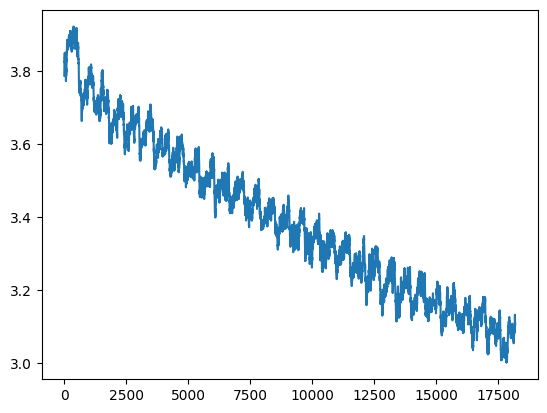

In [41]:
plt.plot(average_losses)

In [44]:
def translate_sentence(model, sentence, eng_tokenizer, hin_tokenizer, device, max_len=MAX_SENT_LEN):
    model.eval()  # Set model to evaluation mode
    
    # 1. Preprocess and Tokenize the input sentence
    sentence = sentence.lower().replace('!', '').replace('.', '').replace('?', '')
    tokens = eng_tokenizer.encode([sentence])[0]
    
    # 2. Pad the sequence (matching your training logic: left-padding)
    padding_idx = eng_tokenizer.word_index[eng_tokenizer.padding_token]
    padded_tokens = [padding_idx] * (max_len - len(tokens)) + tokens
    src_tensor = torch.LongTensor(padded_tokens).unsqueeze(0).to(device) # (1, max_len)

    with torch.no_grad():
        # 3. Pass through Encoder to get the context vector
        _, hidden = model.encoder(src_tensor)

        # 4. Prepare the Decoder input (starting with <|startoftext|>)
        start_idx = hin_tokenizer.word_index[hin_tokenizer.start_token]
        end_idx = hin_tokenizer.word_index[hin_tokenizer.end_token]
        
        input_token = torch.LongTensor([start_idx]).to(device)
        
        translated_indices = []

        # 5. Decode step-by-step
        for _ in range(max_len):
            output, hidden = model.decoder(input_token, hidden)
            
            # Get the word with the highest probability
            top1 = output.argmax(1)
            idx = top1.item()
            
            # Stop if we reach the <|endoftext|> token
            if idx == end_idx:
                break
                
            translated_indices.append(idx)
            input_token = top1 # Next input is the current prediction

    # 6. Convert indices back to words
    translated_sentence = hin_tokenizer.decode([translated_indices])[0]
    return translated_sentence

# --- Usage Example ---
input_str = "india is my country and all indians are my brothers and sisters"
translation = translate_sentence(model, input_str, eng_tokenizer, hin_tokenizer, device)
print(f"Input: {input_str}")
print(f"Output: {translation}")

Input: india is my country and all indians are my brothers and sisters
Output: भारत भारत भारत, भारत, और मेरी मेरी मेरी मेरी मेरी एकमात्र एकमात्र कहानी
